In [ ]:
# Importing required packages

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import os
import shutil
import random
tf.__version__

'2.3.0'

In [ ]:
# Fetching normal x-ray images from kaggle

if os.path.isdir('chest_xray') is False:
    ! pip install -q kaggle
    from google.colab import files
    files.upload()
    ! mkdir ~/.kaggle 
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    ! kaggle datasets list
    ! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
    !unzip chest-xray-pneumonia.zip
    shutil.rmtree('/content/chest_xray/chest_xray')
    shutil.rmtree('/content/chest_xray/__MACOSX')
    os.remove('chest-xray-pneumonia.zip')

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [ ]:
def move_files(source, dest, num_of_samples):
  if num_of_samples=='all':
    filenames = os.listdir(source)
  else:
    filenames = random.sample(os.listdir(source), num_of_samples)
  for fname in filenames:
      srcpath = os.path.join(source, fname)
      shutil.move(srcpath, dest)
  os.chdir('/content')

In [ ]:
# Moving files from kaggle directory to our own directory

if os.path.isdir('/content/covid19_data') is False:
  os.mkdir('covid19_data')
  os.makedirs('/content/covid19_data/train/negative')
  os.makedirs('/content/covid19_data/train/positive')
  os.makedirs('/content/covid19_data/val/negative')
  os.makedirs('/content/covid19_data/val/positive')
  os.makedirs('/content/covid19_data/test/negative')
  os.makedirs('/content/covid19_data/test/positive')
  move_files('/content/chest_xray/train/NORMAL', '/content/covid19_data/train/negative', 800)
  move_files('/content/chest_xray/test/NORMAL', '/content/covid19_data/val/negative', 14)
  move_files('/content/chest_xray/test/NORMAL', '/content/covid19_data/test/negative', 186)
  shutil.rmtree('/content/chest_xray')

In [ ]:
# Fetching covid19 x-ray images from  github link

if os.path.isdir('/content/covid-chestxray-dataset') is False:
  ! git clone https://github.com/ieee8023/covid-chestxray-dataset.git
  positive_path = '/content/covid-chestxray-dataset/images'
  move_files(positive_path, '/content/covid19_data/train/positive', 730)
  move_files(positive_path, '/content/covid19_data/val/positive', 14)
  move_files(positive_path, '/content/covid19_data/test/positive', 186)

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3614 (delta 7), reused 11 (delta 5), pack-reused 3599
Receiving objects: 100% (3614/3614), 633.00 MiB | 45.70 MiB/s, done.
Resolving deltas: 100% (1430/1430), done.
Checking out files: 100% (1173/1173), done.


In [98]:
# Path of the data

train_path = '/content/covid19_data/train'
valid_path = '/content/covid19_data/val'
test_path = '/content/covid19_data/test'

In [99]:
# Data preprocessing

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=['negative', 'positive'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['negative', 'positive'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=['negative', 'positive'], batch_size=10, shuffle=False)

Found 1530 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


In [100]:
# CNN Model

model = Sequential([
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Flatten(),
                    Dense(units=2, activation='softmax')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_664 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_665 (Conv2D)          (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [101]:
# Model training
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=1)

Epoch 1/15
153/153 [==============================] - 45s 293ms/step - loss: 19.1548 - accuracy: 0.9242 - val_loss: 0.5382 - val_accuracy: 0.8214
Epoch 2/15
153/153 [==============================] - 45s 292ms/step - loss: 0.0406 - accuracy: 0.9895 - val_loss: 0.6323 - val_accuracy: 0.7857
Epoch 3/15
153/153 [==============================] - 43s 282ms/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.6964 - val_accuracy: 0.7857
Epoch 4/15
153/153 [==============================] - 43s 283ms/step - loss: 5.4272e-04 - accuracy: 1.0000 - val_loss: 0.7481 - val_accuracy: 0.7857
Epoch 5/15
153/153 [==============================] - 43s 282ms/step - loss: 2.4538e-04 - accuracy: 1.0000 - val_loss: 0.8125 - val_accuracy: 0.7857
Epoch 6/15
153/153 [==============================] - 43s 284ms/step - loss: 1.5335e-04 - accuracy: 1.0000 - val_loss: 0.8685 - val_accuracy: 0.7857
Epoch 7/15
153/153 [==============================] - 43s 281ms/step - loss: 1.0671e-04 - accuracy: 1.0000 - val_loss

In [104]:
model.save('model_cnn.h5')

The accuracy of the model is: 0.9139784946236559
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       186
           1       0.87      0.97      0.92       186

    accuracy                           0.91       372
   macro avg       0.92      0.91      0.91       372
weighted avg       0.92      0.91      0.91       372



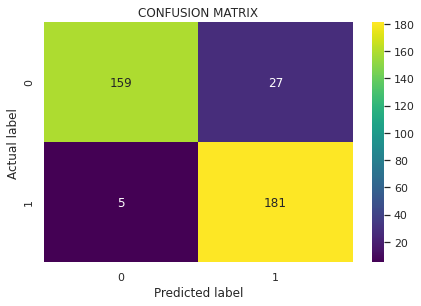

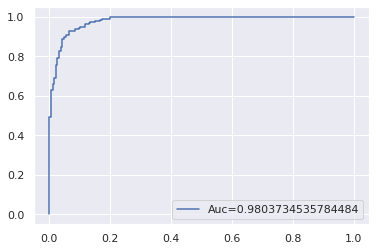

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score

sns.set()

def confusion_matrix_and_report(model, batch_to_pred):
  preds = model.predict(x=batch_to_pred)
  y_preds = np.argmax(preds, axis=-1)
  y_true = batch_to_pred.classes
  accuracy = accuracy_score(y_true, y_preds)
  print(f"The accuracy of the model is: {accuracy}")
  confuse = confusion_matrix(y_true, y_preds)
  report = classification_report(y_true, y_preds)
  print(report)    
  sns.heatmap(pd.DataFrame(confuse), annot=True, cmap='viridis', fmt='g')
  plt.tight_layout()
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')
  plt.title('CONFUSION MATRIX')
  plt.show()

def roc_auc(model, batch_to_pred):
  proba_list = []
  preds = model.predict(x=batch_to_pred)[::,1]
  y_true = batch_to_pred.classes
  fpr, tpr, thresholds = roc_curve(y_true, preds)
  auc = roc_auc_score(y_true, preds)
  plt.plot(fpr,tpr,label="Auc="+str(auc))
  plt.legend(loc=4)

confusion_matrix_and_report(model, test_batches)
roc_auc(model, test_batches)

saved


In [59]:
# VGG16 model

vgg16_model = tf.keras.applications.vgg16.VGG16()

model_vgg16 = Sequential()
for layer in vgg16_model.layers[:-1]: #Except last layer
  model_vgg16.add(layer)

for layer in model_vgg16.layers: #Avoiding training layers
  layer.trainable=False

model_vgg16.add(Dense(units=2, activation='softmax')) #Adding custom last layer
#model.summary()

Epoch 1/5
153/153 [==============================] - 45s 296ms/step - loss: 0.0809 - accuracy: 0.9712 - val_loss: 0.1029 - val_accuracy: 0.9643
Epoch 2/5
153/153 [==============================] - 45s 294ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 3/5
153/153 [==============================] - 45s 294ms/step - loss: 0.0083 - accuracy: 0.9961 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 4/5
153/153 [==============================] - 45s 293ms/step - loss: 0.0076 - accuracy: 0.9961 - val_loss: 0.1381 - val_accuracy: 0.9643
Epoch 5/5
153/153 [==============================] - 45s 295ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 1.0000
The accuracy of the model is: 0.9811827956989247
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       186
           1       0.97      0.99      0.98       186

    accuracy                           0.98       372
   macro avg 

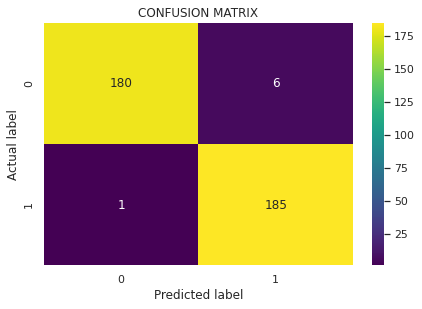

In [60]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=1)

confusion_matrix_and_report(model_vgg16, test_batches)

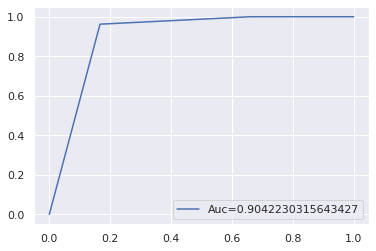

In [122]:
roc_auc(model_vgg16, test_batches)

In [74]:
model_vgg16.save('vgg16_model.h5')
print('SAVED')

SAVED


In [113]:
# Mobile Net

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1530 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


In [114]:
from tensorflow.keras import Model

mobile = tf.keras.applications.mobilenet.MobileNet()
#mobile.summary()
x = mobile.layers[-6].output
output = Dense(units=2, activation='softmax')(x)
model_mobile = Model(inputs=mobile.input, outputs=output)

In [115]:
for layer in model.layers[:-23]:
  layer.trainable=False
model_mobile.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_mobile.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=1)

Epoch 1/5
153/153 [==============================] - 49s 318ms/step - loss: 0.1594 - accuracy: 0.9660 - val_loss: 3.1227e-04 - val_accuracy: 1.0000
Epoch 2/5
153/153 [==============================] - 48s 312ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.0977 - val_accuracy: 0.9643
Epoch 3/5
153/153 [==============================] - 47s 310ms/step - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.1264 - val_accuracy: 0.9286
Epoch 4/5
153/153 [==============================] - 48s 311ms/step - loss: 0.0211 - accuracy: 0.9941 - val_loss: 0.0518 - val_accuracy: 0.9643
Epoch 5/5
153/153 [==============================] - 47s 309ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3713 - val_accuracy: 0.8571


The accuracy of the model is: 0.9489247311827957
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       186
           1       0.91      1.00      0.95       186

    accuracy                           0.95       372
   macro avg       0.95      0.95      0.95       372
weighted avg       0.95      0.95      0.95       372



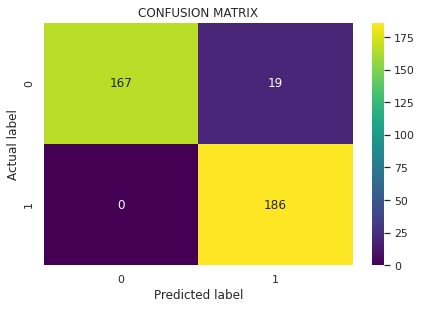

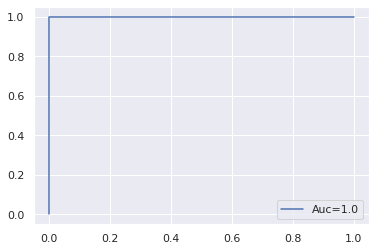

In [123]:
confusion_matrix_and_report(model_mobile, test_batches)
roc_auc(model_mobile, test_batches)

In [73]:
model_mobile.save('model_mobilenet.h5')
print("SAVED")

SAVED


In [151]:
# Predicting our own images

import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing import image

model_dir = '/content/vgg16_model.h5'
image_dir = '/content/2.png'

model_loaded = load_model(model_dir)
img_width, img_height = 224, 224
img = image.load_img(image_dir, target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

result = np.argmax(model_loaded.predict(img), axis=-1)[0]
if(result==1):
  print("COVID19 POSITIVE! TAKE CARE")
else:
  print("COVID19 NEGATIVE! STAY SAFE")

COVID19 POSITIVE! TAKE CARE
